In [1]:
# Ensure PyTorch is installed
# %pip install torch

In [ ]:


# 📦 Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# ⚠️ Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# 🎨 Seaborn plot theme
sns.set_theme(style="whitegrid")

In [3]:
sample_path = "C:/Users/adavy/Downloads/dataset/train_data"
np.load(f'{sample_path}/ID_0A62VH.npy').shape

(64, 64, 12)

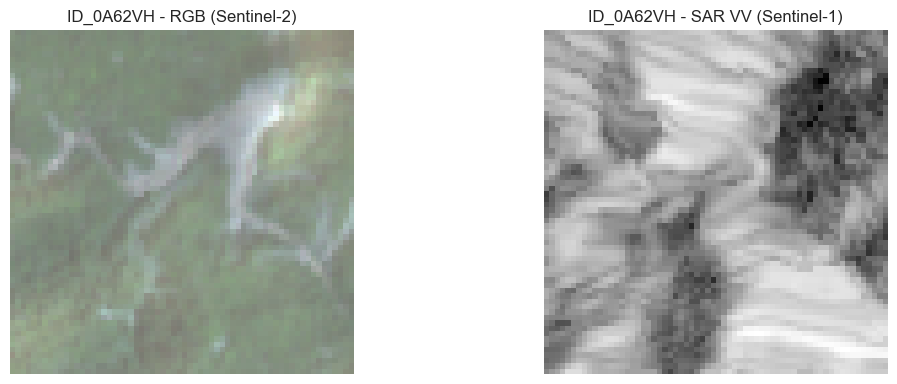

In [4]:
def plot_sample(id_):
    # Load the (64, 64, 12) image and transpose to (12, 64, 64)
    arr = np.load(f'{sample_path}/{id_}.npy')
    arr = np.transpose(arr, (2, 0, 1))  # Now shape is (12, 64, 64)

    rgb = arr[:3].transpose(1, 2, 0)  # Take R, G, B and make it (64, 64, 3)
    vv = arr[4]  # SAR VV polarization as grayscale (channel 4)

    # Normalize RGB data (if it has valid data)
    rgb_max = rgb.max()  # Get the maximum value from RGB data
    rgb = rgb / rgb_max  # Normalize to [0, 1]

    # Clip negative values for SAR VV and normalize to [0, 1]
    vv_min, vv_max = vv.min(), vv.max()
    vv_normalized = (vv - vv_min) / (vv_max - vv_min)  # Normalize to [0, 1]

    # Plotting the RGB and SAR images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb)  # Use normalized RGB data
    plt.title(f"{id_} - RGB (Sentinel-2)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(vv_normalized, cmap='gray')  # Use normalized SAR VV data
    plt.title(f"{id_} - SAR VV (Sentinel-1)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_sample("ID_0A62VH")

In [ ]:
# Load the Dataset
# Read the CSV containing image IDs and their corresponding labels
df = pd.read_csv("C:/Users/adavy/Downloads/dataset/Train.csv")

# Preview the Top Rows
# Display the first three rows of the dataset to get an initial look at the data
df.head(3)

,ID,label
0,ID_HUD1ST,1
1,ID_KGE2HY,1
2,ID_VHV9BL,1


In [ ]:
# Check class distribution to see if the dataset is imbalanced
print("Label distribution:\n")
print(df['label'].value_counts())

Label distribution:

label
0    5892
1    1255
Name: count, dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147 entries, 0 to 7146
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      7147 non-null   object
 1   label   7147 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 111.8+ KB


In [8]:
# Sample 100 image patches randomly and compute band-wise mean
arrs = [np.transpose(np.load(f"{sample_path}/{i}.npy"), (2, 0, 1)) for i in df['ID'].sample(100)]

# Calculate mean value per band across 100 samples
means = np.mean([arr.mean(axis=(1, 2)) for arr in arrs], axis=0)

# Print results
print("Mean values per band (across 100 samples):")
for idx, val in enumerate(means):
    print(f"Band {idx}: {val:.4f}")

Mean values per band (across 100 samples):
Band 0: 1780.8262
Band 1: 1894.1516
Band 2: 1833.3886
Band 3: 3285.4451
Band 4: -10.2067
Band 5: -17.7996
Band 6: -0.8351
Band 7: -0.6300
Band 8: -11.4883
Band 9: -19.5940
Band 10: 0.2927
Band 11: -0.2985


In [9]:
class LandslideDataset(Dataset):
    """
    Custom Dataset for Landslide Detection using multi-channel satellite data.

    Each sample is a (12, 64, 64) tensor representing:
    - 4 Optical bands (RGB + NIR)
    - 2 SAR bands (VV, VH)
    - 6 additional pre/post event or derived bands (if any)

    Args:
        dataframe (pd.DataFrame): DataFrame containing image IDs and labels.
        data_dir (str): Path to directory containing .npy files.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, dataframe, data_dir, transform=None):
        self.df = dataframe
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        id_ = self.df.iloc[idx]['ID']
        label = self.df.iloc[idx]['label']

        # Load .npy file and reshape from (64, 64, 12) to (12, 64, 64)
        file_path = os.path.join(self.data_dir, f"{id_}.npy")
        data = np.load(file_path).astype(np.float32)
        data = np.transpose(data, (2, 0, 1)) / 255.0  # Normalize

        # Apply any optional transforms (e.g., augmentations)
        if self.transform:
            data = self.transform(torch.tensor(data))

        return torch.tensor(data), torch.tensor(label, dtype=torch.long)


In [ ]:
# Perform stratified train-validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Create dataset objects
train_dataset = LandslideDataset(train_df, data_dir=f"{sample_path}")
val_dataset = LandslideDataset(val_df, data_dir=f"{sample_path}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [11]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, in_channels=12):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # Input: (12, 64, 64)
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),  # → (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # → (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # → (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → (128, 8, 8)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  # → (128*8*8)
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # Binary classification (0: no landslide, 1: landslide)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
from tqdm import tqdm

# Initialize your model, optimizer, and criterion (loss function)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Weighted loss to handle imbalance
weights = torch.tensor([1.0, 4.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Lists to store loss, accuracy, and F1 score values
train_losses = []
val_accuracies = []
val_f1_scores = []

# Lists to store loss, accuracy, and F1 score values
train_losses = []
val_accuracies = []
val_f1_scores = []

def train_model(num_epochs=10):
    # best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Track accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        train_losses.append(avg_loss)
        print(f"\nEpoch {epoch+1}, Avg Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
        
        # Evaluate on validation data
        val_accuracy, val_f1 = evaluate_model()
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        # # Optionally save the best model based on validation F1 score
        # if val_f1 > best_val_f1:
        #     best_val_f1 = val_f1
        #     torch.save(model.state_dict(), "best_model.pth")
        #     print("✅ Model saved!")

    plot_metrics()

def evaluate_model():
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\nValidation Accuracy: {accuracy*100:.2f}%")
    print(f"Validation F1 Score: {f1:.4f}")

    return accuracy, f1

def plot_metrics():
    # Plotting the training loss, validation accuracy, and validation F1 score
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label="Validation Accuracy", color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(val_f1_scores, label="Validation F1 Score", color='orange')
    plt.title('Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()

Epoch 1/10:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 1, Avg Loss: 0.8851, Train Accuracy: 62.62%

Validation Accuracy: 46.08%
Validation F1 Score: 0.3934



Epoch 2, Avg Loss: 0.5097, Train Accuracy: 70.26%

Validation Accuracy: 72.73%
Validation F1 Score: 0.5538



Epoch 3, Avg Loss: 0.4634, Train Accuracy: 72.85%

Validation Accuracy: 79.79%
Validation F1 Score: 0.5420



Epoch 4, Avg Loss: 0.4159, Train Accuracy: 76.98%

Validation Accuracy: 77.55%
Validation F1 Score: 0.5962



Epoch 5, Avg Loss: 0.3783, Train Accuracy: 79.38%

Validation Accuracy: 81.26%
Validation F1 Score: 0.6138



Epoch 6, Avg Loss: 0.3644, Train Accuracy: 80.37%

Validation Accuracy: 77.27%
Validation F1 Score: 0.6032



Epoch 7, Avg Loss: 0.3348, Train Accuracy: 82.49%

Validation Accuracy: 84.34%
Validation F1 Score: 0.6489



Epoch 8, Avg Loss: 0.3294, Train Accuracy: 82.81%

Validation Accuracy: 85.73%
Validation F1 Score: 0.6699



Epoch 9, Avg Loss: 0.3125, Train Accuracy: 83.98%

Validation Accuracy: 86.64%
Validation F1 Score: 0.6078



Epoch 10, Avg Loss: 0.3478, Train Accuracy: 82.77%

Validation Accuracy: 78.74%
Validation F1 Score: 0.6000


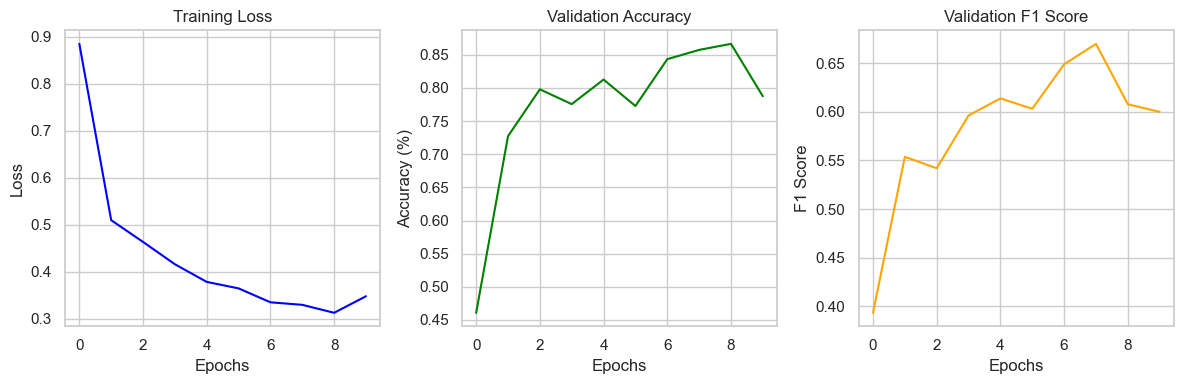

In [13]:
train_model(num_epochs=10)

In [17]:
def landslide_area_stats(model, dataset, patch_area_m2):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data, labels in DataLoader(dataset, batch_size=32):
            data = data.to(device)
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # True/Predicted landslide counts
    true_landslide_count = (all_labels == 1).sum()
    pred_landslide_count = (all_preds == 1).sum()
    total_patches = len(all_labels)

    # Correctly predicted landslides (True Positives)
    correct_landslide_count = ((all_labels == 1) & (all_preds == 1)).sum()
    # Incorrectly predicted landslides (False Positives + False Negatives)
    incorrect_landslide_count = ((all_labels != all_preds) & ((all_labels == 1) | (all_preds == 1))).sum()

    # Areas
    true_area = true_landslide_count * patch_area_m2
    pred_area = pred_landslide_count * patch_area_m2
    correct_area = correct_landslide_count * patch_area_m2
    incorrect_area = incorrect_landslide_count * patch_area_m2

    # Percentage differences
    pct_diff_correct = abs(correct_area - true_area) / true_area * 100 if true_area > 0 else 0
    pct_diff_incorrect = abs(incorrect_area - true_area) / true_area * 100 if true_area > 0 else 0

    print(f"True landslide area: {true_area} m²")
    print(f"Predicted landslide area: {pred_area} m²")
    print(f"Correctly predicted landslide area: {correct_area} m²")
    print(f"Incorrectly predicted landslide area: {incorrect_area} m²")
    print(f"Average % difference (correct): {pct_diff_correct:.2f}%")
    print(f"Average % difference (incorrect): {pct_diff_incorrect:.2f}%")
    print(f"Total patches: {total_patches}")

# Example usage:
landslide_area_stats(model, val_dataset, patch_area_m2=409600)

True landslide area: 102809600 m²
Predicted landslide area: 208486400 m²
Correctly predicted landslide area: 93388800 m²
Incorrectly predicted landslide area: 124518400 m²
Average % difference (correct): 9.16%
Average % difference (incorrect): 21.12%
Total patches: 1430
